In [ ]:
TASK = "depth"  # "pose_single", "pose_multi", "depth"
MODEL = "resnet50 "  # enter model name
N_EPOCHS = 50  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    8  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-3  # enter learning rate
AUGMENTATION = True
CONTINUE_TRAINING = False
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab

In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from microrobot_dl.transform import AddGaussianNoise, TranslateTransform, ZoomTransform
from tqdm import tqdm
import os
import json


torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Load Dataset
num_outputs = 1
mode = None
multi_label = False

if TASK in ["pose_single", "pose_multi"]:
    mode = "pose"
    if TASK == "pose multi":
        multi_label = True
        num_outputs = 2

elif TASK == "depth":
    mode = "depth"

else:
    raise ValueError(f"Task {TASK} not supported yet.")

dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset",
    mode=mode,
    multi_label=multi_label,
    transform=None,
)
print(f"mode: {mode}, num_outputs: {num_outputs}")
print(f"Total samples: {len(dataset)}")

mode: depth, num_outputs: 1
Total samples: 2000


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

if AUGMENTATION:
    if TASK in ["pose_single", "pose_multi"]:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.02),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == "depth":
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15.0),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
else:
    transform_train = transform_test


t_train = transform_train if AUGMENTATION else transform_test
t_test = transform_test

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
    transform_train=t_train,
    transform_test=t_test,
)

In [6]:
# Setup Model
model = get_model(MODEL, num_outputs=num_outputs, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
if TASK == "pose_single":
    criterion = nn.CrossEntropyLoss()
elif TASK == "depth":
    criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
if AUGMENTATION:
    suffix = "_augmented"
else:
    suffix = ""

MODEL_NAME = f"{MODEL}_{TASK}{suffix}"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []  # Stores Accuracy for pose, RMSE for depth
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping


if CONTINUE_TRAINING and os.path.exists(MODEL_PATH):
    print(f"Loading checkpoint from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint.get("val_loss", float("inf"))
    start_epoch = checkpoint.get("epoch", 0)

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        if TASK == "depth":
            labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if TASK == "pose_single":
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)

    if TASK == "pose_single":
        epoch_metric = correct / total
    else:
        epoch_metric = epoch_loss**0.5  # RMSE

    train_losses.append(epoch_loss)
    train_accs.append(epoch_metric)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            if TASK == "depth":
                labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            if TASK == "pose single":
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)

    if TASK == "pose single":
        val_metric = val_correct / val_total
    else:
        val_metric = val_loss**0.5  # RMSE

    val_losses.append(val_loss)
    val_accs.append(val_metric)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_metric": val_metric,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    metric_name = "Acc" if TASK == "pose single" else "RMSE"
    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} {metric_name}: {epoch_metric:.4f} | Val Loss: {val_loss:.4f} {metric_name}: {val_metric:.4f}"
    )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.3331)
Epoch 1/50 - Train Loss: 0.6019 RMSE: 0.7758 | Val Loss: 0.3331 RMSE: 0.5771


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0161)
Epoch 2/50 - Train Loss: 0.0504 RMSE: 0.2244 | Val Loss: 0.0161 RMSE: 0.1271


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0159)
Epoch 3/50 - Train Loss: 0.0219 RMSE: 0.1481 | Val Loss: 0.0159 RMSE: 0.1261


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 4/50 - Train Loss: 0.0382 RMSE: 0.1955 | Val Loss: 0.0195 RMSE: 0.1395


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0089)
Epoch 5/50 - Train Loss: 0.0367 RMSE: 0.1917 | Val Loss: 0.0089 RMSE: 0.0943


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 6/50 - Train Loss: 0.0286 RMSE: 0.1690 | Val Loss: 0.0228 RMSE: 0.1509


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 7/50 - Train Loss: 0.0329 RMSE: 0.1813 | Val Loss: 0.0195 RMSE: 0.1396


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 8/50 - Train Loss: 0.0302 RMSE: 0.1738 | Val Loss: 0.0528 RMSE: 0.2298


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 9/50 - Train Loss: 0.0530 RMSE: 0.2301 | Val Loss: 0.0090 RMSE: 0.0948


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 10/50 - Train Loss: 0.0525 RMSE: 0.2291 | Val Loss: 0.1561 RMSE: 0.3951


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 11/50 - Train Loss: 0.0363 RMSE: 0.1905 | Val Loss: 0.0949 RMSE: 0.3081


100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


Epoch 12/50 - Train Loss: 0.0273 RMSE: 0.1653 | Val Loss: 0.0366 RMSE: 0.1913


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0084)
Epoch 13/50 - Train Loss: 0.0141 RMSE: 0.1187 | Val Loss: 0.0084 RMSE: 0.0915


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 14/50 - Train Loss: 0.0393 RMSE: 0.1982 | Val Loss: 0.0153 RMSE: 0.1236


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 15/50 - Train Loss: 0.0156 RMSE: 0.1248 | Val Loss: 0.0111 RMSE: 0.1055


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0059)
Epoch 16/50 - Train Loss: 0.0454 RMSE: 0.2132 | Val Loss: 0.0059 RMSE: 0.0768


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 17/50 - Train Loss: 0.0251 RMSE: 0.1585 | Val Loss: 0.0231 RMSE: 0.1519


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 18/50 - Train Loss: 0.0172 RMSE: 0.1310 | Val Loss: 0.0086 RMSE: 0.0929


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 19/50 - Train Loss: 0.0359 RMSE: 0.1895 | Val Loss: 0.0457 RMSE: 0.2138


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 20/50 - Train Loss: 0.0281 RMSE: 0.1677 | Val Loss: 0.0834 RMSE: 0.2888


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 21/50 - Train Loss: 0.0171 RMSE: 0.1308 | Val Loss: 0.0146 RMSE: 0.1208


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


Epoch 22/50 - Train Loss: 0.0142 RMSE: 0.1192 | Val Loss: 0.0136 RMSE: 0.1168


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0047)
Epoch 23/50 - Train Loss: 0.0135 RMSE: 0.1160 | Val Loss: 0.0047 RMSE: 0.0686


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 24/50 - Train Loss: 0.0206 RMSE: 0.1434 | Val Loss: 0.0113 RMSE: 0.1063


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 25/50 - Train Loss: 0.0106 RMSE: 0.1030 | Val Loss: 0.0159 RMSE: 0.1259


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 26/50 - Train Loss: 0.0229 RMSE: 0.1515 | Val Loss: 0.0390 RMSE: 0.1974


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 27/50 - Train Loss: 0.0267 RMSE: 0.1633 | Val Loss: 0.0785 RMSE: 0.2801


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 28/50 - Train Loss: 0.0226 RMSE: 0.1502 | Val Loss: 0.0059 RMSE: 0.0766


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 29/50 - Train Loss: 0.0159 RMSE: 0.1262 | Val Loss: 0.0050 RMSE: 0.0709


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0039)
Epoch 30/50 - Train Loss: 0.0114 RMSE: 0.1066 | Val Loss: 0.0039 RMSE: 0.0626


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 31/50 - Train Loss: 0.0237 RMSE: 0.1539 | Val Loss: 0.0061 RMSE: 0.0781


100%|██████████| 45/45 [00:16<00:00,  2.75it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0037)
Epoch 32/50 - Train Loss: 0.0212 RMSE: 0.1455 | Val Loss: 0.0037 RMSE: 0.0606


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 33/50 - Train Loss: 0.0152 RMSE: 0.1235 | Val Loss: 0.0066 RMSE: 0.0812


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


Epoch 34/50 - Train Loss: 0.0121 RMSE: 0.1101 | Val Loss: 0.0184 RMSE: 0.1357


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 35/50 - Train Loss: 0.0148 RMSE: 0.1218 | Val Loss: 0.0050 RMSE: 0.0705


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 36/50 - Train Loss: 0.0071 RMSE: 0.0843 | Val Loss: 0.0069 RMSE: 0.0830


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 37/50 - Train Loss: 0.0168 RMSE: 0.1297 | Val Loss: 0.0195 RMSE: 0.1395


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 38/50 - Train Loss: 0.0191 RMSE: 0.1383 | Val Loss: 0.0081 RMSE: 0.0898


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 39/50 - Train Loss: 0.0044 RMSE: 0.0664 | Val Loss: 0.0047 RMSE: 0.0684


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0030)
Epoch 40/50 - Train Loss: 0.0077 RMSE: 0.0878 | Val Loss: 0.0030 RMSE: 0.0549


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 41/50 - Train Loss: 0.0049 RMSE: 0.0698 | Val Loss: 0.0097 RMSE: 0.0982


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 42/50 - Train Loss: 0.0072 RMSE: 0.0848 | Val Loss: 0.0056 RMSE: 0.0750


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 43/50 - Train Loss: 0.0073 RMSE: 0.0853 | Val Loss: 0.0043 RMSE: 0.0656


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 44/50 - Train Loss: 0.0076 RMSE: 0.0869 | Val Loss: 0.0037 RMSE: 0.0604


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 45/50 - Train Loss: 0.0184 RMSE: 0.1357 | Val Loss: 0.0079 RMSE: 0.0887


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0030)
Epoch 46/50 - Train Loss: 0.0092 RMSE: 0.0960 | Val Loss: 0.0030 RMSE: 0.0543


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Epoch 47/50 - Train Loss: 0.0083 RMSE: 0.0912 | Val Loss: 0.0032 RMSE: 0.0570


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Epoch 48/50 - Train Loss: 0.0098 RMSE: 0.0988 | Val Loss: 0.0151 RMSE: 0.1229


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Saved best model to ../model/resnet50_depth_augmented.pth (Val Loss: 0.0029)
Epoch 49/50 - Train Loss: 0.0102 RMSE: 0.1010 | Val Loss: 0.0029 RMSE: 0.0543


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Epoch 50/50 - Train Loss: 0.0043 RMSE: 0.0659 | Val Loss: 0.0053 RMSE: 0.0731


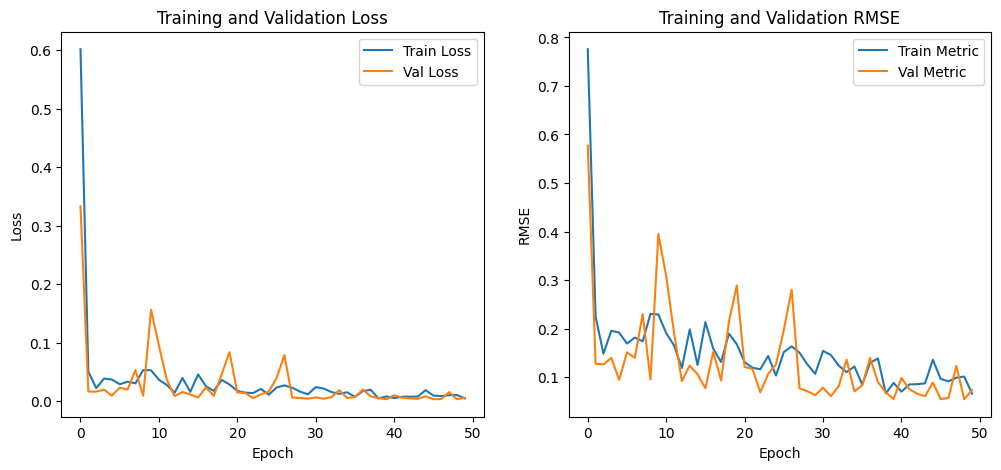

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Metric")
plt.plot(val_accs, label="Val Metric")
plt.xlabel("Epoch")
plt.ylabel("Accuracy" if TASK == "pose single" else "RMSE")
plt.legend()
plt.title(f"Training and Validation {'Accuracy' if TASK == 'pose single' else 'RMSE'}")

plt.show()

In [ ]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_metric_loaded = checkpoint.get("val_metric")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_metric={val_metric_loaded}, val_loss={val_loss_loaded})"
)

model.eval()
test_correct = 0
test_total = 0
test_mse_sum = 0

criterion_test = nn.MSELoss(reduction="sum")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        if TASK == "depth":
            labels = labels.float().unsqueeze(1)

        outputs = model(images)

        if TASK == "pose single":
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        else:
            loss = criterion_test(outputs, labels)
            test_mse_sum += loss.item()
            test_total += labels.size(0)

if TASK == "pose single":
    test_metric = test_correct / test_total
    print(f"Test Set Accuracy: {test_metric:.4f}")
else:
    test_metric = (test_mse_sum / test_total) ** 0.5
    print(f"Test Set RMSE: {test_metric:.4f}")

Loaded checkpoint from ../model/resnet50_depth_augmented.pth (epoch=49, val_metric=0.05428868976480982, val_loss=0.0029472618363797663)
Test Set RMSE: 0.0499


In [ ]:
results = {
    "model_name": MODEL_NAME,
    "metric_name": "accuracy" if TASK in ["pose_single", "pose_multi"] else "rmse",
    "metric_value": test_metric,
    "metadata": {
        "N_EPOCHS": N_EPOCHS + start_epoch if CONTINUE_TRAINING else N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
        "augmentation": AUGMENTATION,
        "learning_rate": LEARNING_RATE,
    },
}

out_dir = f"../eval/{TASK}"｀
out_path = os.path.join(out_dir, f"{MODEL_NAME}.json")

if os.path.exists(out_path):
    try:
        with open(out_path, "r") as f:
            existing = json.load(f)
    except Exception:
        existing = None

    if isinstance(existing, list):
        existing.append(results)
        data_to_write = existing
    elif isinstance(existing, dict):
        data_to_write = [existing, results]
    else:
        data_to_write = [results]
else:
    data_to_write = [results]

with open(out_path, "w") as f:
    json.dump(data_to_write, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to ../eval/depth/resnet50_depth_augmented.json
